In [8]:
using Serialization, Statistics, Distributions, StableRNGs, CSV, ForwardDiff, GlobalSensitivity
include("misc.jl")
include("ode_problem.jl")
include("target_probability.jl")
include("marginal_kl_divergence.jl")
include("sensitivity_analysis.jl");

RNG

In [2]:
rng = StableRNG(34627); #for sampling prior

Input Run Details

In [4]:
#for analysis needing pairs (augmented and baseline comparison)
augmented_run = "200"
baseline_run = "201"
prior_nonbinding_offset = [2,2]
prior_binding_offset = [0,0]
prior_bounds = return_prior_bounds_empirical(prior_nonbinding_offset, prior_binding_offset);

In [20]:
augmented_run = "204"
baseline_run = "205"
bound_offset = [1,1]
binding_bound_offset = [-1,-1]
prior_bounds = return_prior_bounds_empirical(bound_offset, binding_bound_offset) #for target probability
prior_bounds[1] = return_prior_bounds_empirical(bound_offset, [0,-2])[1] #shrink kon by 2 orders of magnitude, keeping ground truth in range

2-element Vector{Float64}:
 -4.714239202420308
 -2.714239202420308

In [21]:
#for analysis needing pairs (augmented and baseline comparison)
augmented_run = "202"
baseline_run = "203"
prior_nonbinding_offset = [3,3]
prior_binding_offset = [1,1]
prior_bounds = return_prior_bounds_empirical(prior_nonbinding_offset, prior_binding_offset);

Calculate Quantiles of Posteriors

In [22]:
#load posterior samples - change name as necessary 
aug_samples = deserialize("outputs/300_$(augmented_run)_posterior_samples_thinned.jls") #ndims x nsamples
baseline_samples = deserialize("outputs/300_$(baseline_run)_posterior_samples_thinned.jls") #ndims x nsamples 
n_parameters, n_samples = size(aug_samples)

#define priors
#prior_bounds = return_prior_bounds_empirical(prior_nonbinding_offset, prior_binding_offset)

#parameter names
parameter_names = return_inferred_parameters()

#ground truth value on log10 scale
ground_truth = log10.(groundtruth_parameter_values())

#calculate quantiles
lower_bound = 0.05
upper_bound = 0.95
my_quantiles = [[Statistics.quantile(baseline_samples[i,:], lower_bound), Statistics.quantile(baseline_samples[i,:], upper_bound)] for i in 1:n_parameters]
my_quantiles_aug = [[Statistics.quantile(aug_samples[i,:], lower_bound), Statistics.quantile(aug_samples[i,:], upper_bound)] for i in 1:n_parameters]
my_quantiles_priors = []
for i in 1:n_parameters
    bounds = prior_bounds[i]
    difference = bounds[2] - bounds[1]
    quantiles_offset = difference*lower_bound
    push!(my_quantiles_priors, [bounds[1]+quantiles_offset, bounds[2]-quantiles_offset])
end

#save 
serialize("outputs/600_$(baseline_run)_posterior_quantiles.jls", my_quantiles)
serialize("outputs/600_$(augmented_run)_posterior_quantiles.jls", my_quantiles_aug)
serialize("outputs/600_$(augmented_run)_prior_quantiles.jls", my_quantiles_priors)

Mean Absolute Error w.r.t. Posterior Samples

In [23]:
#load posterior samples
aug_samples = deserialize("outputs/300_$(augmented_run)_posterior_samples_thinned.jls") #ndims x nsamples
baseline_samples = deserialize("outputs/300_$(baseline_run)_posterior_samples_thinned.jls") #ndims x nsamples 
n_parameters, n_samples = size(aug_samples)

#parameter names
parameter_names = return_inferred_parameters()

#ground truth value on log10 scale
ground_truth = log10.(groundtruth_parameter_values())

#calculate absolute error of each sample
abs_error = Base.stack([abs.(baseline_samples[:,i] .- ground_truth) for i in 1:n_samples])
abs_error_reg = Base.stack([abs.(aug_samples[:,i] .- ground_truth) for i in 1:n_samples])

#take mean of absolute errors for each parameter
mae = [sum(abs_error[i,:])/n_samples for i in 1:n_parameters]
mae_reg = [sum(abs_error_reg[i,:])/n_samples for i in 1:n_parameters]

#convert to dictionary
mae_dict = Dict(parameter_names[i] => mae[i] for i in 1:n_parameters)
mae_aug_dict = Dict(parameter_names[i] => mae_reg[i] for i in 1:n_parameters)

#save 
serialize("outputs/600_$(baseline_run)_mean_absolute_error.jls", mae_dict)
serialize("outputs/600_$(augmented_run)_mean_absolute_error.jls", mae_aug_dict)

Calculate KL Divergence for From Augmented to Baseline Posterior

In [24]:
#load posterior samples
aug_samples = deserialize("outputs/300_$(augmented_run)_posterior_samples_thinned.jls") #ndims x nsamples
baseline_samples = deserialize("outputs/300_$(baseline_run)_posterior_samples_thinned.jls") #ndims x nsamples 
n_parameters, n_samples = size(aug_samples)
#prior_bounds = return_prior_bounds_empirical(prior_nonbinding_offset, prior_binding_offset)
prior_distributions = [Uniform(prior_bounds[i]...) for i in 1:n_parameters]
prior_samples = transpose(Base.stack([rand(rng, prior_distributions[i], n_samples) for i in 1:n_parameters])) #ndims x nsamples 

#parameter names
parameter_names = return_inferred_parameters()
kl_div_augmented_baseline, parameter_names = kl_divergence_bits_samples(aug_samples, baseline_samples, parameter_names)
kl_div_baseline_prior, parameter_names = kl_divergence_bits_samples(baseline_samples, prior_samples, parameter_names)

#save
serialize("outputs/600_$(augmented_run)_$(baseline_run)_kl_div.jls", kl_div_augmented_baseline)
serialize("outputs/600_$(baseline_run)_prior_kl_div.jls", kl_div_augmented_baseline)

Calculate quantiles of finegrain predictions for which we have experimental data

In [25]:
data_files = readdir("data")
sort_files = data_files .!= ".DS_Store"
data_files = sort(data_files[sort_files]) #sort to ensure consistent order
sort_files = data_files .!= "predicted_kd.csv"
data_files = sort(data_files[sort_files])
quantity_names = [replace(data_files[i], ".csv" => "") for i in 1:length(data_files)];

In [26]:
for r in [augmented_run, baseline_run]    
    for i in quantity_names
        predictions = Base.stack(deserialize("outputs/500_$(r)_finegrain_predictions_$(i).jls")) #ntime x n
        n_time_points, n_predictions = size(predictions)
        uq = 0.95
        lq = 0.05
        m = 0.5
        quantile_up = [Statistics.quantile(predictions[i,:], uq) for i in 1:n_time_points]
        quantile_low = [Statistics.quantile(predictions[i,:], lq) for i in 1:n_time_points]
        median = [Statistics.quantile(predictions[i,:], m) for i in 1:n_time_points]
        serialize("outputs/600_$(r)_prediction_quantiles_$(i).jls", Dict("lower_quantile"=>quantile_low, 
        "median"=>median, "upper_quantile" =>quantile_up))
    end
end

Calculate Quantiles of Predictions for All Species

In [28]:
#calculate quantiles
for r in [augmented_run, baseline_run]
    all_predictions = deserialize("outputs/500_$(r)_predictions.jls")
    n_doses, n_samples = size(all_predictions)
    n_species = length(all_predictions[1].u[1])
    n_time_points = length(all_predictions[1].u);
    reshaped_predictions = []
    for i in 1:n_doses
        p_per_dose = all_predictions[i,:]
        for z in 1:n_species
            species_dose = zeros(n_time_points, n_samples)
            for j in 1:n_samples
                species_dose[:,j] = Base.stack(p_per_dose[j].u)[z,:]
            end
            reshaped_predictions = cat(reshaped_predictions, [Base.stack(species_dose)], dims=1)
        end
    end
    quantiles = []   
    for j in 1:(n_doses*n_species)
        predictions = reshaped_predictions[j]
        uq = 0.95
        lq = 0.05
        m = 0.5
        quantile_up = [Statistics.quantile(predictions[i,:], uq) for i in 1:n_time_points]
        quantile_low = [Statistics.quantile(predictions[i,:], lq) for i in 1:n_time_points]
        median = [Statistics.quantile(predictions[i,:], m) for i in 1:n_time_points]
        quantiles = cat(quantiles, [Dict("lower_quantile"=>quantile_low, "median"=>median, "upper_quantile" =>quantile_up)], dims=1)
    end
    serialize("outputs/600_$(r)_prediction_quantiles.jls", quantiles)
end

LoadError: EOFError: read end of file

In [ ]:
#calculate quantiles for finegrain predictions
for r in [augmented_run, baseline_run]
    all_predictions = deserialize("outputs/500_$(r)_predictions_finegrain.jls")
    n_doses, n_samples = size(all_predictions)
    n_species = length(all_predictions[1].u[1])
    n_time_points = length(all_predictions[1].u);
    reshaped_predictions = []
    for i in 1:n_doses
        p_per_dose = all_predictions[i,:]
        for z in 1:n_species
            species_dose = zeros(n_time_points, n_samples)
            for j in 1:n_samples
                species_dose[:,j] = Base.stack(p_per_dose[j].u)[z,:]
            end
            reshaped_predictions = cat(reshaped_predictions, [Base.stack(species_dose)], dims=1)
        end
    end
    quantiles = []   
    for j in 1:(n_doses*n_species)
        predictions = reshaped_predictions[j]
        uq = 0.95
        lq = 0.05
        m = 0.5
        quantile_up = [Statistics.quantile(predictions[i,:], uq) for i in 1:n_time_points]
        quantile_low = [Statistics.quantile(predictions[i,:], lq) for i in 1:n_time_points]
        median = [Statistics.quantile(predictions[i,:], m) for i in 1:n_time_points]
        quantiles = cat(quantiles, [Dict("lower_quantile"=>quantile_low, "median"=>median, "upper_quantile" =>quantile_up)], dims=1)
    end
    serialize("outputs/600_$(r)_prediction_quantiles_finegrain.jls", quantiles)
end 

LoadError: EOFError: read end of file

Local Sensitivity Analysis

In [22]:
#first, extract parameter set that maximizes baseline training data likelihood
likelihood = deserialize("outputs/300_$(baseline_run)_posterior_samples_thinned_likelihood.jls");
max_likelihood = maximum(likelihood)
mask = likelihood .== max_likelihood
max_likelihood_parameters = deserialize("outputs/300_$(baseline_run)_posterior_samples_thinned.jls")[:, mask]

#calculate local sensitivity of each species about this parameter value 
normalize_to = normalize_to_dose()
ligand_doses = cat(return_ligand_dose_nM(),normalize_to, dims=1)
n_doses = length(ligand_doses)
n_species = 5
solver_inputs = return_ode_problem_solver_default_inputs("timecourse")
solver_inputs["reltol"] = 1.0e-12
solver_inputs["abstol"] = 1.0e-9

#initialize storage
local_sensitivity_kb = []
local_sensitivity_kf = []
local_sensitivity_nonbinding = []
for i in 1:n_doses
    odesys, u0, tspan, p = return_ode_problem_default_inputs(ligand_doses[i])
    odeprob = DifferentialEquations.ODEProblem(odesys, u0, tspan, p) #note, parameters will be redefined in next function
    for j in 1:n_species
        local_sensitivity = ForwardDiff.jacobian(p -> local_sensitivity_analysis(p, odeprob, solver_inputs, j), max_likelihood_parameters)
        local_sensitivity_kb = cat(local_sensitivity_kb, [local_sensitivity[:,return_koff_indices()]], dims=1)
        local_sensitivity_kf = cat(local_sensitivity_kf, [local_sensitivity[:, return_kon_indices()]], dims=1)
        local_sensitivity_nonbinding = cat(local_sensitivity_nonbinding, [local_sensitivity[:, return_nonbinding_indices()]], dims=1)
    end
end
serialize("outputs/600_$(baseline_run)_local_sensitivity_kb.jls", local_sensitivity_kb)
serialize("outputs/600_$(baseline_run)_local_sensitivity_kf.jls", local_sensitivity_kf)
serialize("outputs/600_$(baseline_run)_local_sensitivity_nonbind.jls", local_sensitivity_nonbinding)


#Reshape and save for correlation calculation between change in median and local sensitivity of parameters
#calculate absolute difference between medians for each output of interest
augmented_quantiles = deserialize("outputs/600_$(augmented_run)_prediction_quantiles.jls")
baseline_quantiles = deserialize("outputs/600_$(baseline_run)_prediction_quantiles.jls")
n_outputs = length(augmented_quantiles) #n_species x n_doses
n_timepoints = length(augmented_quantiles[1]["median"])
difference_between_medians = []
for i in 1:n_outputs
    difference_between_medians = cat(difference_between_medians, [abs.(augmented_quantiles[i]["median"] .- baseline_quantiles[i]["median"])], dims=1)
end
#save
med_dif = reshape(Base.stack(difference_between_medians), n_outputs*n_timepoints)
serialize("outputs/600_$(baseline_run)_$(augmented_run)_difference_between_medians_1d.jls", med_dif)

#load local sensitivity to parameter for each output of interest, reshape to match median difference, save
for i in ["kb", "kf", "nonbind"]
    local_sensitivity_kb = deserialize("outputs/600_$(baseline_run)_local_sensitivity_$(i).jls") #vector of n_outputs, each output is sensitivity matrix of n_timepoints x n_parameters
    #maximum across kb
    max_ls_kb = []
    for i in 1:n_outputs
        max_ls_kb = cat(max_ls_kb, [vec(maximum(abs.(local_sensitivity_kb[i]), dims=2))], dims=1) #take parameter with highest sensitivity for particular output
    end
    ls_kb = reshape(Base.stack(max_ls_kb), n_outputs*n_timepoints)
    serialize("outputs/600_$(baseline_run)_local_sensitivity_$(i)_1d.jls", ls_kb)
end

Perturbation Analysis

In [4]:
#first, extract parameter set that maximizes baseline training data likelihood
likelihood = deserialize("outputs/300_$(baseline_run)_posterior_samples_thinned_likelihood.jls");
max_likelihood = maximum(likelihood)
mask = likelihood .== max_likelihood
max_likelihood_parameters = deserialize("outputs/300_$(baseline_run)_posterior_samples_thinned.jls")[:, mask]

#calculate local sensitivity of each species about this parameter value 
normalize_to = normalize_to_dose()
ligand_doses = cat(return_ligand_dose_nM(),normalize_to, dims=1)
n_doses = length(ligand_doses)
n_species = 5
solver_inputs = return_ode_problem_solver_default_inputs("timecourse")
solver_inputs["reltol"] = 1.0e-12
solver_inputs["abstol"] = 1.0e-9

local_sensitivity_kb = []
local_sensitivity_kf = []
local_sensitivity_nonbinding = [] 
for i in 1:n_doses 
    odesys, u0, tspan, p = return_ode_problem_default_inputs(ligand_doses[i])
    odeprob = DifferentialEquations.ODEProblem(odesys, u0, tspan, p) #note, parameters will be redefined in next function
    for j in 1:n_species
        local_sensitivity = ForwardDiff.jacobian(p -> local_sensitivity_analysis_absolute(p, odeprob, solver_inputs, j), 10.0.^max_likelihood_parameters) #take parameters out of log10scale first
        #multiple by 5% change in parameter value 
        n_outputs, n_parameters = size(local_sensitivity)
        percent_change = transpose(reshape(repeat((10.0.^max_likelihood_parameters).*0.05, n_outputs),n_parameters, n_outputs))
        local_sensitivity = local_sensitivity.*percent_change
        local_sensitivity_kb = cat(local_sensitivity_kb, [local_sensitivity[:,return_koff_indices()]], dims=1)
        local_sensitivity_kf = cat(local_sensitivity_kf, [local_sensitivity[:, return_kon_indices()]], dims=1)
        local_sensitivity_nonbinding = cat(local_sensitivity_nonbinding, [local_sensitivity[:, return_nonbinding_indices()]], dims=1)
    end
end
serialize("outputs/600_$(baseline_run)_5_percent_change_kb.jls", local_sensitivity_kb)
serialize("outputs/600_$(baseline_run)_5_percent_change_kf.jls", local_sensitivity_kf)
serialize("outputs/600_$(baseline_run)_5_percent_change_nonbind.jls", local_sensitivity_nonbinding)


#Reshape and save for correlation calculation between change in median and local sensitivity of parameters
#calculate absolute difference between medians for each output of interest
augmented_quantiles = deserialize("outputs/600_$(augmented_run)_prediction_quantiles.jls")
baseline_quantiles = deserialize("outputs/600_$(baseline_run)_prediction_quantiles.jls")
n_outputs = length(augmented_quantiles) #n_species x n_doses
n_timepoints = length(augmented_quantiles[1]["median"])
difference_between_medians = []
for i in 1:n_outputs
    difference_between_medians = cat(difference_between_medians, [abs.(augmented_quantiles[i]["median"] .- baseline_quantiles[i]["median"])], dims=1)
end
#save
med_dif = reshape(Base.stack(difference_between_medians), n_outputs*n_timepoints)
serialize("outputs/600_$(baseline_run)_$(augmented_run)_difference_between_medians_1d.jls", med_dif)

#load local sensitivity to parameter for each output of interest, reshape to match median difference, save
for i in ["kb", "kf", "nonbind"]
    local_sensitivity_kb = deserialize("outputs/600_$(baseline_run)_5_percent_change_$(i).jls") #vector of n_outputs, each output is sensitivity matrix of n_timepoints x n_parameters
    #maximum across kb
    max_ls_kb = []
    for i in 1:n_outputs
        max_ls_kb = cat(max_ls_kb, [vec(maximum(abs.(local_sensitivity_kb[i]), dims=2))], dims=1) #take parameter with highest sensitivity for particular output
    end
    ls_kb = reshape(Base.stack(max_ls_kb), n_outputs*n_timepoints)
    serialize("outputs/600_$(baseline_run)_5_percent_change_$(i)_1d.jls", ls_kb)
end

Global Sensitivity Analysis About Max Likelihood Parameters - Changing IC

In [21]:
#global sensitivity analysis about maximum likelihood parameter set 
#first, extract parameter set that maximizes baseline training data likelihood
likelihood = deserialize("outputs/300_$(baseline_run)_posterior_samples_thinned_likelihood.jls");
max_likelihood = maximum(likelihood)
mask = likelihood .== max_likelihood
max_likelihood_parameters = deserialize("outputs/300_$(baseline_run)_posterior_samples_thinned.jls")[:, mask]
n_parameters = length(max_likelihood_parameters)
n_species = 5

#ode problem definition
normalize_to = normalize_to_dose()
ligand_doses = cat(return_ligand_dose_nM(),normalize_to, dims=1) #normalize to last stimulation
n_doses = length(ligand_doses)
odesys, u0, tspan, p = return_ode_problem_default_inputs(ligand_doses[end]) #dose will be set later, this is simply to define ode problem
odeprob = DifferentialEquations.ODEProblem(odesys, u0, tspan, p) #note, parameters and initial conditions will be redefined in next function

#ode solver inputs
solver_inputs = return_ode_problem_solver_default_inputs("timecourse")
solver_inputs["reltol"] = 1.0e-6
solver_inputs["abstol"] = 1.0e-5
solver_inputs["saveat"] = [10, 30, 60, 120, 210, 300, 450, 600] #redefine to exclude tp 0
solver_inputs["solver"] = AutoTsit5(Rosenbrock23())

#sensitivity analysis parameters
#initial conditions first
#vary non-zero initial conditions by an order of magnitude
non_zero_ic_mask = u0 .!= 0.0
non_zero_ic_mask[2] = 0 #exclude ligand dose
non_zero_ic = u0[non_zero_ic_mask] #exclude ligand dose
n_ic = length(non_zero_ic)
non_zero_ic = log10.(non_zero_ic)
lb_ic = non_zero_ic.-0.1
ub_ic = non_zero_ic.+0.1
bounds_ic = [[lb_ic[i],ub_ic[i]] for i in 1:n_ic];
#get parameter bounds based on max likelihood parameters, already in logscale
lb = max_likelihood_parameters.-1
ub = max_likelihood_parameters.+1
bounds = [[lb[i],ub[i]] for i in 1:n_parameters]
push!(bounds, [-2,0]) #dummy parameter
total_bounds = cat(bounds_ic, bounds, dims=1) #all bounds to vary

Ns = 500 #sample size, needs to be bigger than 2*num_harmonics*omega_max, where num_harmonics = 4 and omega_max = 11 (number of parameters) 
#calculate local sensitivity of each species about this parameter value 
result = GlobalSensitivity.gsa(p -> global_sensitivity_analysis_ic(p, ligand_doses, odeprob, solver_inputs, n_species, non_zero_ic_mask), eFAST(), total_bounds, samples=Ns)
#replace NaN with 0 sensitivity
result.S1[isnan.(result.S1)] .= 0
result.ST[isnan.(result.ST)] .= 0
serialize("outputs/600_$(baseline_run)_global_sensitivity_about_max_likelihood_value.jls", result); #ST and S1, each (n_doses x n_species x n_timepoints) x n_parameters+1

┌ Warning: At t=0.0010753139826785007, dt was forced below floating point epsilon 2.168404344971009e-19, and step error estimate = 21.32155871625189. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/Zrnkf/src/integrator_interface.jl:623
┌ Warning: At t=0.0010753139853856492, dt was forced below floating point epsilon 2.168404344971009e-19, and step error estimate = 21.32156021413491. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/Zrnkf/src/integrator_interface.jl:623
┌ Warning: At t=0.0010753139875775732, dt was forced below floating point epsilon 2.168404344971009e-19, and step error estimate = 21.321555259100627. Aborting. There is either an error in your mode

ligand dose 1 
initial values: [11887.45, 5.18, 0.0, 11887.45, 0.0]ligand dose 2 
initial values: [11887.45, 51.79, 0.0, 11887.45, 0.0]ligand dose 3 
initial values: [11887.45, 103.58, 0.0, 11887.45, 0.0]ligand dose 4 
initial values: [11887.45, 258.95, 0.0, 11887.45, 0.0]ligand dose 5 
initial values: [11887.45, 517.89, 0.0, 11887.45, 0.0]ligand dose 6 
initial values: [11887.45, 1035.78, 0.0, 11887.45, 0.0]ligand dose 7 
initial values: [11887.45, 2589.46, 0.0, 11887.45, 0.0]ligand dose 8 
initial values: [11887.45, 5178.92, 0.0, 11887.45, 0.0]ligand dose 9 
initial values: [11887.45, 51789.2, 0.0, 11887.45, 0.0]ligand dose 1 
initial values: [10604.46, 5.18, 0.0, 11865.57, 0.0]ligand dose 2 
initial values: [10604.46, 51.79, 0.0, 11865.57, 0.0]ligand dose 3 
initial values: [10604.46, 103.58, 0.0, 11865.57, 0.0]ligand dose 4 
initial values: [10604.46, 258.95, 0.0, 11865.57, 0.0]ligand dose 5 
initial values: [10604.46, 517.89, 0.0, 11865.57, 0.0]ligand dose 6 
initial values: [1060

┌ Warning: At t=0.0035928045058407974, dt was forced below floating point epsilon 4.336808689942018e-19, and step error estimate = 21.321557382413047. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/Zrnkf/src/integrator_interface.jl:623
┌ Warning: At t=0.003592805950815809, dt was forced below floating point epsilon 4.336808689942018e-19, and step error estimate = 21.32154439474901. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/Zrnkf/src/integrator_interface.jl:623
┌ Warning: At t=0.003920258890686675, dt was forced below floating point epsilon 8.673617379884035e-19, and step error estimate = 21.321554348998276. Aborting. There is either an error in your model

ligand dose 7 
initial values: [12063.93, 2589.46, 0.0, 11542.2, 0.0]ligand dose 8 
initial values: [12063.93, 5178.92, 0.0, 11542.2, 0.0]ligand dose 9 
initial values: [12063.93, 51789.2, 0.0, 11542.2, 0.0]ligand dose 1 
initial values: [10761.9, 5.18, 0.0, 11520.96, 0.0]ligand dose 2 
initial values: [10761.9, 51.79, 0.0, 11520.96, 0.0]ligand dose 3 
initial values: [10761.9, 103.58, 0.0, 11520.96, 0.0]ligand dose 4 
initial values: [10761.9, 258.95, 0.0, 11520.96, 0.0]ligand dose 5 
initial values: [10761.9, 517.89, 0.0, 11520.96, 0.0]ligand dose 6 
initial values: [10761.9, 1035.78, 0.0, 11520.96, 0.0]ligand dose 7 
initial values: [10761.9, 2589.46, 0.0, 11520.96, 0.0]ligand dose 8 
initial values: [10761.9, 5178.92, 0.0, 11520.96, 0.0]ligand dose 9 
initial values: [10761.9, 51789.2, 0.0, 11520.96, 0.0]ligand dose 1 
initial values: [9600.39, 5.18, 0.0, 11499.76, 0.0]ligand dose 2 
initial values: [9600.39, 51.79, 0.0, 11499.76, 0.0]ligand dose 3 
initial values: [9600.39, 103.58

┌ Warning: At t=0.00556620959071138, dt was forced below floating point epsilon 8.673617379884035e-19, and step error estimate = 21.32155655033356. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/Zrnkf/src/integrator_interface.jl:623
┌ Warning: At t=0.0055662203263961135, dt was forced below floating point epsilon 8.673617379884035e-19, and step error estimate = 21.321556854400434. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/Zrnkf/src/integrator_interface.jl:623
┌ Warning: At t=0.005566220173693894, dt was forced below floating point epsilon 8.673617379884035e-19, and step error estimate = 21.321544961507584. Aborting. There is either an error in your model 

ligand dose 4 
initial values: [8258.69, 258.95, 0.0, 11457.47, 0.0]ligand dose 5 
initial values: [8258.69, 517.89, 0.0, 11457.47, 0.0]ligand dose 6 
initial values: [8258.69, 1035.78, 0.0, 11457.47, 0.0]ligand dose 7 
initial values: [8258.69, 2589.46, 0.0, 11457.47, 0.0]ligand dose 8 
initial values: [8258.69, 5178.92, 0.0, 11457.47, 0.0]ligand dose 9 
initial values: [8258.69, 51789.2, 0.0, 11457.47, 0.0]ligand dose 1 
initial values: [9257.87, 5.18, 0.0, 11436.38, 0.0]ligand dose 2 
initial values: [9257.87, 51.79, 0.0, 11436.38, 0.0]ligand dose 3 
initial values: [9257.87, 103.58, 0.0, 11436.38, 0.0]ligand dose 4 
initial values: [9257.87, 258.95, 0.0, 11436.38, 0.0]ligand dose 5 
initial values: [9257.87, 517.89, 0.0, 11436.38, 0.0]ligand dose 6 
initial values: [9257.87, 1035.78, 0.0, 11436.38, 0.0]ligand dose 7 
initial values: [9257.87, 2589.46, 0.0, 11436.38, 0.0]ligand dose 8 
initial values: [9257.87, 5178.92, 0.0, 11436.38, 0.0]ligand dose 9 
initial values: [9257.87, 517

┌ Warning: At t=0.023362667115192547, dt was forced below floating point epsilon 3.469446951953614e-18, and step error estimate = 21.321553967378417. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/Zrnkf/src/integrator_interface.jl:623
┌ Warning: At t=0.02336266736080888, dt was forced below floating point epsilon 3.469446951953614e-18, and step error estimate = 21.32155657172397. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/Zrnkf/src/integrator_interface.jl:623
┌ Warning: At t=0.02336266810407531, dt was forced below floating point epsilon 3.469446951953614e-18, and step error estimate = 21.3215544758436. Aborting. There is either an error in your model spec

ligand dose 1 
initial values: [9122.44, 5.18, 0.0, 11104.24, 0.0]ligand dose 2 
initial values: [9122.44, 51.79, 0.0, 11104.24, 0.0]ligand dose 3 
initial values: [9122.44, 103.58, 0.0, 11104.24, 0.0]ligand dose 4 
initial values: [9122.44, 258.95, 0.0, 11104.24, 0.0]ligand dose 5 
initial values: [9122.44, 517.89, 0.0, 11104.24, 0.0]ligand dose 6 
initial values: [9122.44, 1035.78, 0.0, 11104.24, 0.0]ligand dose 7 
initial values: [9122.44, 2589.46, 0.0, 11104.24, 0.0]ligand dose 8 
initial values: [9122.44, 5178.92, 0.0, 11104.24, 0.0]ligand dose 9 
initial values: [9122.44, 51789.2, 0.0, 11104.24, 0.0]ligand dose 1 
initial values: [10226.13, 5.18, 0.0, 11083.8, 0.0]ligand dose 2 
initial values: [10226.13, 51.79, 0.0, 11083.8, 0.0]ligand dose 3 
initial values: [10226.13, 103.58, 0.0, 11083.8, 0.0]ligand dose 4 
initial values: [10226.13, 258.95, 0.0, 11083.8, 0.0]ligand dose 5 
initial values: [10226.13, 517.89, 0.0, 11083.8, 0.0]ligand dose 6 
initial values: [10226.13, 1035.78,

┌ Warning: At t=0.03707749123185812, dt was forced below floating point epsilon 6.938893903907228e-18, and step error estimate = 21.32155846354736. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/Zrnkf/src/integrator_interface.jl:623
┌ Warning: At t=0.03707749441100782, dt was forced below floating point epsilon 6.938893903907228e-18, and step error estimate = 21.321556757877016. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/Zrnkf/src/integrator_interface.jl:623
┌ Warning: At t=0.03707749815347214, dt was forced below floating point epsilon 6.938893903907228e-18, and step error estimate = 21.32155487529416. Aborting. There is either an error in your model spec

ligand dose 3 
initial values: [12333.57, 103.58, 0.0, 11043.04, 0.0]ligand dose 4 
initial values: [12333.57, 258.95, 0.0, 11043.04, 0.0]ligand dose 5 
initial values: [12333.57, 517.89, 0.0, 11043.04, 0.0]ligand dose 6 
initial values: [12333.57, 1035.78, 0.0, 11043.04, 0.0]ligand dose 7 
initial values: [12333.57, 2589.46, 0.0, 11043.04, 0.0]ligand dose 8 
initial values: [12333.57, 5178.92, 0.0, 11043.04, 0.0]ligand dose 9 
initial values: [12333.57, 51789.2, 0.0, 11043.04, 0.0]ligand dose 1 
initial values: [11002.43, 5.18, 0.0, 11022.72, 0.0]ligand dose 2 
initial values: [11002.43, 51.79, 0.0, 11022.72, 0.0]ligand dose 3 
initial values: [11002.43, 103.58, 0.0, 11022.72, 0.0]ligand dose 4 
initial values: [11002.43, 258.95, 0.0, 11022.72, 0.0]ligand dose 5 
initial values: [11002.43, 517.89, 0.0, 11022.72, 0.0]ligand dose 6 
initial values: [11002.43, 1035.78, 0.0, 11022.72, 0.0]ligand dose 7 
initial values: [11002.43, 2589.46, 0.0, 11022.72, 0.0]ligand dose 8 
initial values: 

┌ Warning: At t=0.15091368005315894, dt was forced below floating point epsilon 2.7755575615628914e-17, and step error estimate = 21.3855813826568. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/Zrnkf/src/integrator_interface.jl:623
┌ Warning: At t=0.15091375698105966, dt was forced below floating point epsilon 2.7755575615628914e-17, and step error estimate = 21.387919096468668. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/Zrnkf/src/integrator_interface.jl:623
┌ Warning: At t=0.15091383581963574, dt was forced below floating point epsilon 2.7755575615628914e-17, and step error estimate = 21.38852178610305. Aborting. There is either an error in your model sp

ligand dose 9 
initial values: [12516.67, 51789.2, 0.0, 10722.32, 0.0]ligand dose 1 
initial values: [11165.77, 5.18, 0.0, 10702.59, 0.0]ligand dose 2 
initial values: [11165.77, 51.79, 0.0, 10702.59, 0.0]ligand dose 3 
initial values: [11165.77, 103.58, 0.0, 10702.59, 0.0]ligand dose 4 
initial values: [11165.77, 258.95, 0.0, 10702.59, 0.0]ligand dose 5 
initial values: [11165.77, 517.89, 0.0, 10702.59, 0.0]ligand dose 6 
initial values: [11165.77, 1035.78, 0.0, 10702.59, 0.0]ligand dose 7 
initial values: [11165.77, 2589.46, 0.0, 10702.59, 0.0]ligand dose 8 
initial values: [11165.77, 5178.92, 0.0, 10702.59, 0.0]ligand dose 9 
initial values: [11165.77, 51789.2, 0.0, 10702.59, 0.0]ligand dose 1 
initial values: [9960.67, 5.18, 0.0, 10682.89, 0.0]ligand dose 2 
initial values: [9960.67, 51.79, 0.0, 10682.89, 0.0]ligand dose 3 
initial values: [9960.67, 103.58, 0.0, 10682.89, 0.0]ligand dose 4 
initial values: [9960.67, 258.95, 0.0, 10682.89, 0.0]ligand dose 5 
initial values: [9960.67

┌ Warning: At t=0.07788256167452086, dt was forced below floating point epsilon 1.3877787807814457e-17, and step error estimate = 21.505304304916933. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/Zrnkf/src/integrator_interface.jl:623
┌ Warning: At t=0.07788262146364508, dt was forced below floating point epsilon 1.3877787807814457e-17, and step error estimate = 21.507131639997215. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/Zrnkf/src/integrator_interface.jl:623
┌ Warning: At t=0.07788278071938377, dt was forced below floating point epsilon 1.3877787807814457e-17, and step error estimate = 21.508562308238016. Aborting. There is either an error in your model

ligand dose 6 
initial values: [11331.54, 1035.78, 0.0, 10391.75, 0.0]ligand dose 7 
initial values: [11331.54, 2589.46, 0.0, 10391.75, 0.0]ligand dose 8 
initial values: [11331.54, 5178.92, 0.0, 10391.75, 0.0]ligand dose 9 
initial values: [11331.54, 51789.2, 0.0, 10391.75, 0.0]ligand dose 1 
initial values: [10108.55, 5.18, 0.0, 10372.63, 0.0]ligand dose 2 
initial values: [10108.55, 51.79, 0.0, 10372.63, 0.0]ligand dose 3 
initial values: [10108.55, 103.58, 0.0, 10372.63, 0.0]ligand dose 4 
initial values: [10108.55, 258.95, 0.0, 10372.63, 0.0]ligand dose 5 
initial values: [10108.55, 517.89, 0.0, 10372.63, 0.0]ligand dose 6 
initial values: [10108.55, 1035.78, 0.0, 10372.63, 0.0]ligand dose 7 
initial values: [10108.55, 2589.46, 0.0, 10372.63, 0.0]ligand dose 8 
initial values: [10108.55, 5178.92, 0.0, 10372.63, 0.0]ligand dose 9 
initial values: [10108.55, 51789.2, 0.0, 10372.63, 0.0]ligand dose 1 
initial values: [9017.55, 5.18, 0.0, 10353.54, 0.0]ligand dose 2 
initial values: [

┌ Warning: At t=0.0741163551982807, dt was forced below floating point epsilon 1.3877787807814457e-17, and step error estimate = 582.4087213300963. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/Zrnkf/src/integrator_interface.jl:623
┌ Warning: At t=0.07411754707736448, dt was forced below floating point epsilon 1.3877787807814457e-17, and step error estimate = 21.53011884405413. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/Zrnkf/src/integrator_interface.jl:623
┌ Warning: At t=0.07411962023776239, dt was forced below floating point epsilon 1.3877787807814457e-17, and step error estimate = 21.391509705727174. Aborting. There is either an error in your model sp

ligand dose 5 
initial values: [8044.31, 517.89, 0.0, 10334.48, 0.0]ligand dose 6 
initial values: [8044.31, 1035.78, 0.0, 10334.48, 0.0]ligand dose 7 
initial values: [8044.31, 2589.46, 0.0, 10334.48, 0.0]ligand dose 8 
initial values: [8044.31, 5178.92, 0.0, 10334.48, 0.0]ligand dose 9 
initial values: [8044.31, 51789.2, 0.0, 10334.48, 0.0]ligand dose 1 
initial values: [8792.48, 5.18, 0.0, 10315.46, 0.0]ligand dose 2 
initial values: [8792.48, 51.79, 0.0, 10315.46, 0.0]ligand dose 3 
initial values: [8792.48, 103.58, 0.0, 10315.46, 0.0]ligand dose 4 
initial values: [8792.48, 258.95, 0.0, 10315.46, 0.0]ligand dose 5 
initial values: [8792.48, 517.89, 0.0, 10315.46, 0.0]ligand dose 6 
initial values: [8792.48, 1035.78, 0.0, 10315.46, 0.0]ligand dose 7 
initial values: [8792.48, 2589.46, 0.0, 10315.46, 0.0]ligand dose 8 
initial values: [8792.48, 5178.92, 0.0, 10315.46, 0.0]ligand dose 9 
initial values: [8792.48, 51789.2, 0.0, 10315.46, 0.0]ligand dose 1 
initial values: [9856.24, 5.

┌ Warning: At t=0.14936816017029292, dt was forced below floating point epsilon 2.7755575615628914e-17, and step error estimate = 21.32155788708016. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/Zrnkf/src/integrator_interface.jl:623
┌ Warning: At t=0.14938420659390328, dt was forced below floating point epsilon 2.7755575615628914e-17, and step error estimate = 21.321555888362816. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/Zrnkf/src/integrator_interface.jl:623
┌ Warning: At t=0.14941135024426622, dt was forced below floating point epsilon 2.7755575615628914e-17, and step error estimate = 21.321557127803082. Aborting. There is either an error in your model 

ligand dose 2 
initial values: [8663.86, 51.79, 0.0, 10015.87, 0.0]ligand dose 3 
initial values: [8663.86, 103.58, 0.0, 10015.87, 0.0]ligand dose 4 
initial values: [8663.86, 258.95, 0.0, 10015.87, 0.0]ligand dose 5 
initial values: [8663.86, 517.89, 0.0, 10015.87, 0.0]ligand dose 6 
initial values: [8663.86, 1035.78, 0.0, 10015.87, 0.0]ligand dose 7 
initial values: [8663.86, 2589.46, 0.0, 10015.87, 0.0]ligand dose 8 
initial values: [8663.86, 5178.92, 0.0, 10015.87, 0.0]

┌ Warning: At t=0.455904662579997, dt was forced below floating point epsilon 5.551115123125783e-17, and step error estimate = 21.32154186341725. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/Zrnkf/src/integrator_interface.jl:623
┌ Warning: At t=0.4970641653850098, dt was forced below floating point epsilon 5.551115123125783e-17, and step error estimate = 21.321534453146562. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/Zrnkf/src/integrator_interface.jl:623
┌ Warning: At t=2.4719917155236963, dt was forced below floating point epsilon 4.440892098500626e-16, and step error estimate = 21.405573708956375. Aborting. There is either an error in your model specifi

ligand dose 1 
initial values: [9712.06, 5.18, 0.0, 10002.56, 0.0]ligand dose 2 
initial values: [9712.06, 51.79, 0.0, 10002.56, 0.0]ligand dose 3 
initial values: [9712.06, 103.58, 0.0, 10002.56, 0.0]ligand dose 4 
initial values: [9712.06, 258.95, 0.0, 10002.56, 0.0]ligand dose 5 
initial values: [9712.06, 517.89, 0.0, 10002.56, 0.0]ligand dose 6 
initial values: [9712.06, 1035.78, 0.0, 10002.56, 0.0]ligand dose 7 
initial values: [9712.06, 2589.46, 0.0, 10002.56, 0.0]ligand dose 1 
initial values: [10887.08, 5.18, 0.0, 10021.0, 0.0]ligand dose 2 
initial values: [10887.08, 51.79, 0.0, 10021.0, 0.0]ligand dose 3 
initial values: [10887.08, 103.58, 0.0, 10021.0, 0.0]ligand dose 4 
initial values: [10887.08, 258.95, 0.0, 10021.0, 0.0]ligand dose 5 
initial values: [10887.08, 517.89, 0.0, 10021.0, 0.0]ligand dose 6 
initial values: [10887.08, 1035.78, 0.0, 10021.0, 0.0]ligand dose 7 
initial values: [10887.08, 2589.46, 0.0, 10021.0, 0.0]ligand dose 8 
initial values: [10887.08, 5178.92,

┌ Warning: At t=0.011556600527002196, dt was forced below floating point epsilon 1.734723475976807e-18, and step error estimate = 21.39512126743778. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/Zrnkf/src/integrator_interface.jl:623
┌ Warning: At t=0.011556598198565813, dt was forced below floating point epsilon 1.734723475976807e-18, and step error estimate = 21.393630935445554. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/Zrnkf/src/integrator_interface.jl:623
┌ Warning: At t=0.011556597866131281, dt was forced below floating point epsilon 1.734723475976807e-18, and step error estimate = 21.39302020022104. Aborting. There is either an error in your model s

LoadError: DimensionMismatch: number of rows of each array must match (got [45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 80, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 115, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 290, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 80, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 360, 45, 45, 45, 185, 360, 360, 360, 360, 45, 45, 45, 80, 360, 360, 360, 360, 45, 45, 45, 80, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 80, 45, 45, 45, 325, 360, 360, 360, 360, 45, 45, 45, 80, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 360, 360, 360, 360, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 80, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 185, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 80, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 325, 185, 80, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 80, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 80, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 80, 80, 80, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 150, 290, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 80, 45, 80, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 115, 290, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 80, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 185, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 80, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 115, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 150, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 220, 80, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 80, 185, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 80, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 115, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 115, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 80, 80, 115, 150, 290, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 80, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 150, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 80, 80, 80, 115, 290, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 115, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 80, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 80, 80, 80, 115, 185, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 325, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360])

PCA of Posterior Samples

In [ ]:
using MultivariateStats

In [6]:
u0 = log10.([round(10000.18493,digits=2), round(5.178920000000001, digits=2), 0.0, round(10003.49982, digits=2), 0.0])
p = cat(u0[[1,4]], max_likelihood_parameters, dims=1)

10×1 Matrix{Float64}:
  4.000007817230319
  4.000151976474334
 -4.459132560241765
 -4.264040341670706
 -1.058296300846258
 -5.089227645078012
  0.8876414993172608
 -5.186394698909447
 -2.4237088662495894
 -0.9597596051740018

In [9]:
solver_inputs["saveat"] = [10, 30, 60, 120, 210, 300, 450, 600] #redefine to exclude tp 0
out = global_sensitivity_analysis_ic(p, ligand_doses, odeprob, solver_inputs, n_species, non_zero_ic_mask)

┌ Warning: At t=3.336399368325778, dt was forced below floating point epsilon 4.440892098500626e-16, and step error estimate = 1.0209517427753414. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/Zrnkf/src/integrator_interface.jl:623


ligand dose 1 
initial values: [10000.18, 5.18, 0.0, 10003.5, 0.0]

325-element Vector{Float64}:
 10019.711104003765
     5.180000000000092
     5.9722829513738
     1.3322910063357584e14
     0.7386743372499783
  9897.77176227383
  9698.692068724464
  9413.844324350175
  8890.209787791317
  8207.024149618856
  7628.748155289002
  6853.77901732037
  6263.652814458564
     ⋮
  7008.851920187005
  7418.129263869
  7913.609022641572
  8226.604744434597
  3512.1480616321323
  4068.9580041101476
  3878.734767902554
  3492.541787094429
  2989.89391516596
  2580.616654682067
  2085.1370404612926
  1772.1414518872773

In [52]:
out 

45-element Vector{Float64}:
 11000.0
     5.178920000000001
     0.0
 10200.0
     0.0
 11000.0
    51.7892
     0.0
 10200.0
     0.0
 11000.0
   103.5784
     0.0
     ⋮
 10200.0
     0.0
 11000.0
  5178.92
     0.0
 10200.0
     0.0
 11000.0
 51789.200000000004
     0.0
 10200.0
     0.0

In [40]:
10.0.^max_likelihood_parameters

8×1 Matrix{Float64}:
 3.4743009873852965e-5
 5.4445207626950346e-5
 0.08743870142198422
 8.14277350617057e-6
 7.720430172037567
 6.510364450752853e-6
 0.0037695641089168395
 0.10970852972264518

In [39]:
[10.0.^total_bounds[i] for i in 1:length(total_bounds)]

11-element Vector{Vector{Float64}}:
 [9772.372209558112, 10232.929922807536]
 [9772.372209558112, 10232.929922807536]
 [3.474300987385297e-6, 0.0003474300987385297]
 [5.4445207626950344e-6, 0.0005444520762695035]
 [0.008743870142198422, 0.8743870142198422]
 [8.142773506170569e-7, 8.14277350617057e-5]
 [0.7720430172037567, 77.20430172037567]
 [6.510364450752853e-7, 6.510364450752853e-5]
 [0.0003769564108916839, 0.0376956410891684]
 [0.010970852972264519, 1.0970852972264518]
 [0.010000000000000002, 1.0]

Global Sensitivity Analysis using Prior Bounds - Changing IC

In [35]:
#global sensitivity analysis about maximum likelihood parameter set 
#first, extract parameter set that maximizes baseline training data likelihood
likelihood = deserialize("outputs/300_$(baseline_run)_posterior_samples_thinned_likelihood.jls");
max_likelihood = maximum(likelihood)
mask = likelihood .== max_likelihood
max_likelihood_parameters = deserialize("outputs/300_$(baseline_run)_posterior_samples_thinned.jls")[:, mask]
n_parameters = length(max_likelihood_parameters)
n_species = 5

#ode problem definition
normalize_to = normalize_to_dose()
ligand_doses = cat(return_ligand_dose_nM(),normalize_to, dims=1) #normalize to last stimulation
n_doses = length(ligand_doses)
odesys, u0, tspan, p = return_ode_problem_default_inputs(ligand_doses[end]) #dose will be set later, this is simply to define ode problem
odeprob = DifferentialEquations.ODEProblem(odesys, u0, tspan, p) #note, parameters and initial conditions will be redefined in next function

#ode solver inputs
solver_inputs = return_ode_problem_solver_default_inputs("timecourse")
solver_inputs["reltol"] = 1.0e-12
solver_inputs["abstol"] = 1.0e-12
#solver_inputs["saveat"] = [0, 10, 30, 60, 120, 210, 300, 450, 600] #redefine to exclude tp 0

#sensitivity analysis parameters
#initial conditions first
#vary non-zero initial conditions by an order of magnitude
non_zero_ic_mask = u0 .!= 0.0
non_zero_ic_mask[2] = 0 #exclude ligand dose
non_zero_ic = u0[non_zero_ic_mask] #exclude ligand dose
n_ic = length(non_zero_ic)
non_zero_ic = log10.(non_zero_ic)
lb_ic = non_zero_ic.-0.01
ub_ic = non_zero_ic.+0.01
bounds_ic = [[lb_ic[i],ub_ic[i]] for i in 1:n_ic];
#use prior bounds defined earlier when setting run info
push!(prior_bounds, [-2,0]) #dummy parameter
total_bounds = cat(bounds_ic, prior_bounds, dims=1) #all bounds to vary, IC first

Ns = 500 #sample size, needs to be bigger than 2*num_harmonics*omega_max, where num_harmonics = 4 and omega_max = 11 (number of parameters) 
#calculate local sensitivity of each species about this parameter value 
result = GlobalSensitivity.gsa(p -> global_sensitivity_analysis_ic(p, ligand_doses, odeprob, solver_inputs, n_species, non_zero_ic_mask), eFAST(), total_bounds, samples=Ns)
#replace NaN with 0 sensitivity
result.S1[isnan.(result.S1)] .= 0
result.ST[isnan.(result.ST)] .= 0
serialize("outputs/600_$(baseline_run)_global_sensitivity_about_max_likelihood_value.jls", result); #ST and S1, each (n_doses x n_species x n_timepoints) x n_parameters+1

LoadError: InterruptException:

Global Sensitivity Analysis with Priors

In [ ]:
#global sensitivity analysis about maximum likelihood parameter set 
#first, extract parameter set that maximizes baseline training data likelihood
likelihood = deserialize("outputs/300_$(baseline_run)_posterior_samples_thinned_likelihood.jls");
max_likelihood = maximum(likelihood)
mask = likelihood .== max_likelihood
max_likelihood_parameters = deserialize("outputs/300_$(baseline_run)_posterior_samples_thinned.jls")[:, mask]
n_parameters = length(max_likelihood_parameters)
n_species = 5

#ode problem definition
normalize_to = normalize_to_dose()
ligand_doses = cat(return_ligand_dose_nM(),normalize_to, dims=1) #normalize to last stimulation
n_doses = length(ligand_doses)
odesys, u0, tspan, p = return_ode_problem_default_inputs(ligand_doses[end]) #dose will be set later, this is simply to define ode problem
odeprob = DifferentialEquations.ODEProblem(odesys, u0, tspan, p) #note, parameters and initial conditions will be redefined in next function

#ode solver inputs
solver_inputs = return_ode_problem_solver_default_inputs("timecourse")
solver_inputs["reltol"] = 1.0e-12
solver_inputs["abstol"] = 1.0e-9
solver_inputs["saveat"] = [10, 30, 60, 120, 210, 300, 450, 600] #redefine to exclude tp 0

#sensitivity analysis parameters
#initial conditions first
#vary non-zero initial conditions by an order of magnitude
non_zero_ic_mask = u0 .!= 0.0
non_zero_ic_mask[2] = 0 #exclude ligand dose
non_zero_ic = u0[non_zero_ic_mask] #exclude ligand dose
n_ic = length(non_zero_ic)
non_zero_ic = log10.(non_zero_ic)
lb_ic = non_zero_ic.-1
ub_ic = non_zero_ic.+1
bounds_ic = [[lb_ic[i],ub_ic[i]] for i in 1:n_ic];
#get parameter bounds based on max likelihood parameters
lb = max_likelihood_parameters.-0.2
ub = max_likelihood_parameters.+0.2
bounds = [[lb[i],ub[i]] for i in 1:n_parameters]
push!(bounds, [-2,0]) #dummy parameter
total_bounds = cat(bounds_ic, bounds, dims=1) #all bounds to vary 
total_bounds = total_bounds #exclude ligand dose, which we set for comparison with simulations 

Ns = 500 #sample size, needs to be bigger than 2*num_harmonics*omega_max, where num_harmonics = 4 and omega_max = 11 (number of parameters) 
#calculate local sensitivity of each species about this parameter value 
result = GlobalSensitivity.gsa(p -> global_sensitivity_analysis(p, ligand_doses, odeprob, solver_inputs, n_species, non_zero_ic_mask), eFAST(), total_bounds, samples=Ns)
#replace NaN with 0 sensitivity
result.S1[isnan.(result.S1)] .= 0
result.ST[isnan.(result.ST)] .= 0
serialize("outputs/600_$(baseline_run)_global_sensitivity_about_max_likelihood_value.jls", result); #ST and S1, each (n_doses x n_species x n_timepoints) x n_parameters+1

In [15]:
#global sensitivity analysis about maximum likelihood parameter set 
#first, extract parameter set that maximizes baseline training data likelihood
likelihood = deserialize("outputs/300_$(baseline_run)_posterior_samples_thinned_likelihood.jls");
max_likelihood = maximum(likelihood)
mask = likelihood .== max_likelihood
max_likelihood_parameters = deserialize("outputs/300_$(baseline_run)_posterior_samples_thinned.jls")[:, mask]
n_parameters = length(max_likelihood_parameters)
n_species = 5
#sensitivity analysis parameters
#get bounds based on max likelihood parameters
lb = max_likelihood_parameters.-1
ub = max_likelihood_parameters.+1
bounds = [[lb[i],ub[i]] for i in 1:n_parameters]
push!(bounds, [-2,0]) #dummy parameter
Ns = 10000 #sample size, needs to be bigger than 2*num_harmonics*omega_max, where num_harmonics = 4 and omega_max = 8 (number of parameters) 
#ode problem definition
#calculate local sensitivity of each species about this parameter value 
normalize_to = normalize_to_dose()
ligand_doses = cat(return_ligand_dose_nM(),normalize_to, dims=1) #normalize to last stimulation
n_doses = length(ligand_doses)
n_species = 5
solver_inputs = return_ode_problem_solver_default_inputs("timecourse")

odesys, u0, tspan, p = return_ode_problem_default_inputs(ligand_doses[end])
odeprob = DifferentialEquations.ODEProblem(odesys, u0, tspan, p) #note, parameters will be redefined in next function
result = GlobalSensitivity.gsa(p -> global_sensitivity_analysis(p, ligand_doses, odeprob, solver_inputs, n_species), eFAST(), bounds, samples=Ns)
#replace NaN with 0 sensitivity
result.S1[isnan.(result.S1)] .= 0
result.ST[isnan.(result.ST)] .= 0
serialize("outputs/600_$(baseline_run)_global_sensitivity_about_max_likelihood_value.jls", result); #ST and S1, each (n_doses x n_species x n_timepoints) x n_parameters+1

In [17]:
#global sensitivity analysis with priors
bounds = return_prior_bounds_empirical([2,2],[0,0])
push!(bounds, [-4,0]) #dummy parameter
Ns = 10000 #sample size, needs to be bigger than 2*num_harmonics*omega_max, where num_harmonics = 4 and omega_max = 8 (number of parameters) 
#ode problem definition
normalize_to = normalize_to_dose()
ligand_doses = cat(return_ligand_dose_nM(),normalize_to, dims=1) #normalize to last stimulation
n_doses = length(ligand_doses)
n_species = 5
solver_inputs = return_ode_problem_solver_default_inputs("timecourse")
#higher tolerances needed for wider search space 
solver_inputs["reltol"] = 1.0e-12
solver_inputs["abstol"] = 1.0e-9

odesys, u0, tspan, p = return_ode_problem_default_inputs(ligand_doses[end])
odeprob = DifferentialEquations.ODEProblem(odesys, u0, tspan, p) #note, parameters and initial conditions will be redefined in next function
result = GlobalSensitivity.gsa(p -> global_sensitivity_analysis(p, ligand_doses, odeprob, solver_inputs, n_species), eFAST(), bounds, samples=Ns)
#replace NaN with 0 sensitivity
result.S1[isnan.(result.S1)] .= 0
result.ST[isnan.(result.ST)] .= 0
serialize("outputs/600_$(baseline_run)_global_sensitivity_prior_bounds.jls", result); #ST and S1, each (n_doses x n_species x n_timepoints) x n_parameters+1

In [18]:
path = ["outputs/600_$(baseline_run)_global_sensitivity_prior_bounds", "outputs/600_$(baseline_run)_global_sensitivity_about_max_likelihood_value"]
for p in path
    save_global_sensitivity_indices_1d(p)
end

In [ ]:
global_sensitivity_nonbinding = sum(result.S1[:,return_nonbinding_indices()], dims=2)
global_sensitivity_kb = result.S1[:,return_koff_indices()]
global_sensitivity_kf = result.S1[:,return_kon_indices()]

45×1 Matrix{Float64}:
 0.0
 0.952257064414132
 0.6498238775980206
 0.3473280328808432
 0.1981941321979138
 0.16847908168628073
 0.1642758739601098
 0.16221506699295327
 0.1606508029406419
 0.0
 0.0003506881961097106
 0.00035494174951132107
 0.0003540960254754372
 ⋮
 1.211025769484332e-6
 3.2064779898708352e-6
 4.213963818281826e-6
 0.0
 0.01976659645446403
 0.00206554652763975
 0.00014531367541200198
 2.208285871386796e-6
 4.341292745882769e-7
 1.165930994443774e-6
 3.237924065504669e-6
 4.205409941906061e-6

In [ ]:
global_sensitivity_nonbinding = sum(result.ST[:,return_nonbinding_indices()], dims=2)
global_sensitivity_kb = sum(result.ST[:,return_koff_indices()], dims=2)
global_sensitivity_kf = sum(result.ST[:,return_kon_indices()], dims=2)

45×1 Matrix{Float64}:
 0.0
 0.9829822310451259
 0.9113305505803606
 0.844368447335955
 0.817753490573092
 0.8138411935779329
 0.8132799271943669
 0.8128410197228595
 0.8124297925075251
 0.0
 0.8759704304179168
 0.8760680406605243
 0.8758352989771423
 ⋮
 0.006274248238773539
 0.007450964360993351
 0.007855647340775818
 0.0
 0.049637897366507144
 0.008962201299447803
 0.0044939162975631275
 0.003979289503626027
 0.005040309683251087
 0.006306846748689088
 0.007465348824223228
 0.00788286447841946

In [ ]:
med_dif = deserialize("outputs/600_$(baseline_run)_$(augmented_run)_difference_between_medians_1d.jls");

In [ ]:
Statistics.cor(med_dif[361:end], vec(global_sensitivity_nonbinding))

-0.24718688591065613

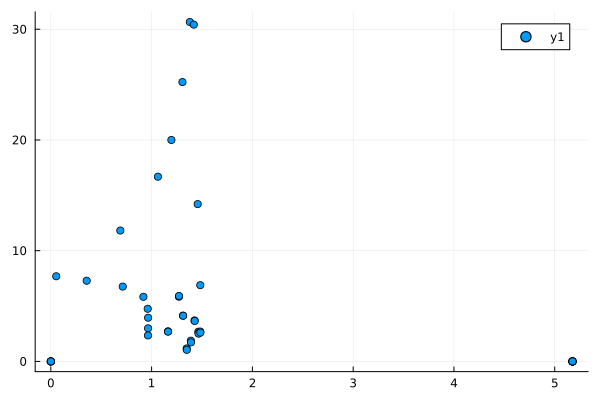

In [ ]:
using Plots
scatter(global_sensitivity_nonbinding, med_dif[361:end])

In [ ]:
med_dif

405-element Vector{Float64}:
   0.0
   3.229836482390965
  10.969570463226773
  23.920657799342735
  55.150368807428094
 110.73246432182168
 172.08639413247693
 278.3746319975453
 381.8277284436772
   0.0
   8.881784197001252e-16
   8.881784197001252e-16
   8.881784197001252e-16
   ⋮
   3.704307686685752
   2.6829029182572413
   2.6986551452209824
   0.0
   2.6880225173558756
   5.913428581779499
   4.1233788116642245
   1.048426372648919
   1.7199683590474706
   3.652232336119141
   2.5076958992494838
   2.604979922362645